# Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [ ]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import skimage

In [ ]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 249 kB/s 


In [ ]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:0


In [ ]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [ ]:
class_labels[897]

'washer'

### Task I: manual explanation with smoothgrad (2 points)

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [ ]:
# Seems like data was not normalized by ImageNet mean and std everywhere in
# original notebook. 
# (https://github.com/yandexdataschool/Practical_DL/blob/fall22/week07_interpretability/practice.ipynb)

# I will change the code and use a new convinient pytorch interface for 
# interaction with pretrained models.
# (https://pytorch.org/vision/stable/models.html)

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()
model.to(device)

preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image_tensor = read_image('img.jpg')
plt.imshow(image_tensor.permute(1, 2, 0))
plt.show()

with torch.no_grad():
    batch = preprocess(image_tensor).unsqueeze(0).to(device)
    probs = torch.softmax(model(batch), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

#1: p=0.083	Labrador_retriever (208)
#2: p=0.077	boxer (242)
#3: p=0.047	Brabancon_griffon (262)
#4: p=0.028	pug (254)
#5: p=0.027	American_Staffordshire_terrier (180)
#6: p=0.026	Staffordshire_bullterrier (179)
#7: p=0.024	seat_belt (785)
#8: p=0.022	bull_mastiff (243)
#9: p=0.020	Chesapeake_Bay_retriever (209)
#10: p=0.019	bluetick (164)


Now let's implement SmoothGrad itself.

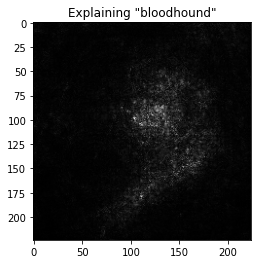

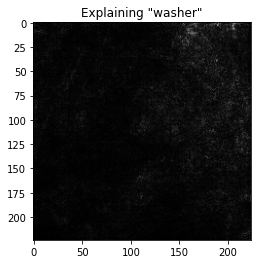

In [ ]:
def explain_smoothgrad(image_tensor: torch.Tensor, class_ix, num_runs=32, sigma=0.1):
    batched_image = preprocess(image_tensor).unsqueeze(0).to(device)
    batched_image = batched_image.requires_grad_(True)
    
    # repeat image tensor several times, add different noise to each copy
    repeated_images = batched_image.repeat(num_runs, 1, 1, 1)
    noisy_images = repeated_images + sigma * torch.randn_like(repeated_images)
    
    class_scores = model(noisy_images)[:, class_ix]
    class_scores.sum().backward()  # backpropagate to image_tensor
    return abs(batched_image.grad).mean(dim=1)[0].cpu().numpy()

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image_tensor, class_ix), cmap='gray')
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

#1: p=0.207	bow_tie (457)
#2: p=0.108	suit (834)
#3: p=0.018	Windsor_tie (906)
#4: p=0.016	marimba (642)
#5: p=0.013	oboe (683)
#6: p=0.013	bassoon (432)
#7: p=0.010	French_horn (566)
#8: p=0.009	notebook (681)
#9: p=0.007	cello (486)
#10: p=0.006	accordion (401)


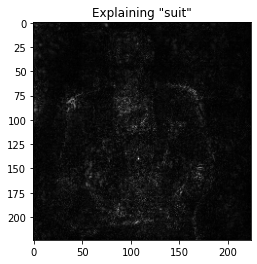

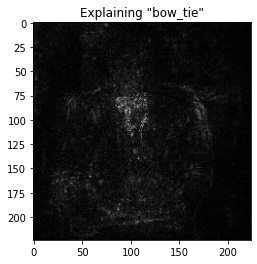

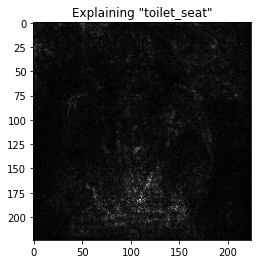

In [ ]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image_tensor = read_image('img.jpg')
plt.imshow(image_tensor.permute(1, 2, 0))
plt.show()

with torch.no_grad():
    batch = preprocess(image_tensor).unsqueeze(0).to(device)
    probs = torch.softmax(model(batch), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image_tensor, class_ix), cmap='gray')
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [ ]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import shap

In [ ]:
from PIL import Image

shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.cat([preprocess(Image.fromarray((x * 255).astype(np.uint8)))[None] for x in background])
background = background.to(device)

In [ ]:
background.size()

torch.Size([50, 3, 224, 224])

In [ ]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg

image_tensor = read_image('img.jpg')
batch = preprocess(image_tensor).unsqueeze(0).to(device)

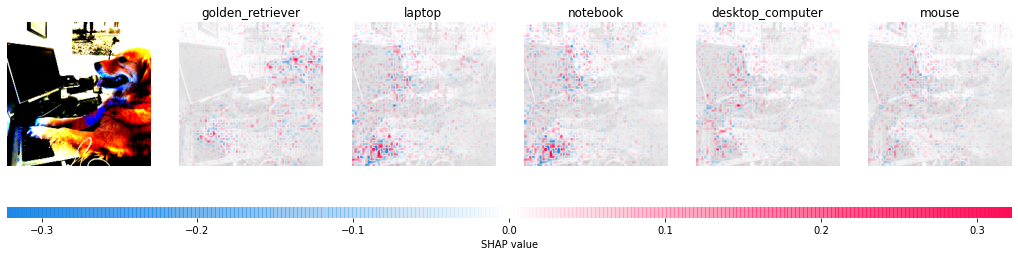

In [ ]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)

shap_values, indices = explainer.shap_values(batch, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())

shap.image_plot(shap_values, batch.permute(0, 2, 3, 1).cpu().numpy(), index_names)

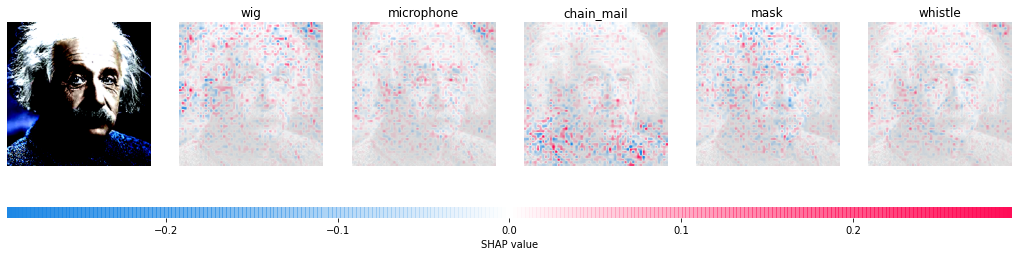

In [ ]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg

image_tensor = read_image('img.jpg')
batch = preprocess(image_tensor).unsqueeze(0).to(device)

explainer = shap.GradientExplainer((model, model.layer1), background)

shap_values, indices = explainer.shap_values(batch, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())

shap.image_plot(shap_values, batch.permute(0, 2, 3, 1).cpu().numpy(), index_names)

###### Explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting. 

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

**NB: the following cells requires JavaScript support and should work in Jupyter (not JupyterLab or cocalc)**. 
In that case try running it on Google colab: https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import catboost # pip install catboost

shap.initjs()

X, y = shap.datasets.boston()
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X)

# visualize explanation of the first example
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [ ]:
# Explain training data: each *column* is a rotated plot from above, stacked for all training samples
# (this plot is interactive, hover mouse to see feature names)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, X)

### Task II: Explain Intermediate Layers of Resnet50 on ImageNet (5 points)

Sometimes, computing explanations w.r.t. pixels is more difficult (and less interpretable) than using intermediate layers that are closer to the "output" layer. The trick is to compute low-resolution explanations of output w.r.t. intermediate layer and then resizing them to fit the original image.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to features like eyes and brows, and deeper layers capture entire objects.

**Your task** is to explain ResNet50 model outputs with respect to the convolution module from 2nd  and 4th layer of the pretrained Resnet50 network using the same GradientExplainer. *The task may require some googling or browsing the [docs](https://shap.readthedocs.io/en/latest) :)*

**Please use at least 10 images from across the internet (or from ImageNet) and compare the 2nd and 4th layer explanations on these images.**


In [ ]:
# Could not understand the task ;(
# What should differ from the previous "explains"?
# What is "convolution module in layerX"? There are 13 convolutions in each layer.

In [ ]:
def denormalize(batch):
    mean = torch.as_tensor([0.485, 0.456, 0.406], device=batch.device)
    std = torch.as_tensor([0.229, 0.224, 0.225], device=batch.device)

    mean = mean.view(1, 3, 1, 1)
    std = std.view(1, 3, 1, 1)

    return batch * std + mean

In [ ]:
import os

# images from https://github.com/EliSchwartz/imagenet-sample-images

batch = []
for imname in os.listdir('images'):
    image_tensor = read_image(os.path.join('images', imname))
    batch.append(
        preprocess(image_tensor).unsqueeze(0)
    )
batch = torch.cat(batch).to(device)

torch.Size([10, 3, 224, 224]) torch.Size([1, 3, 1, 1])


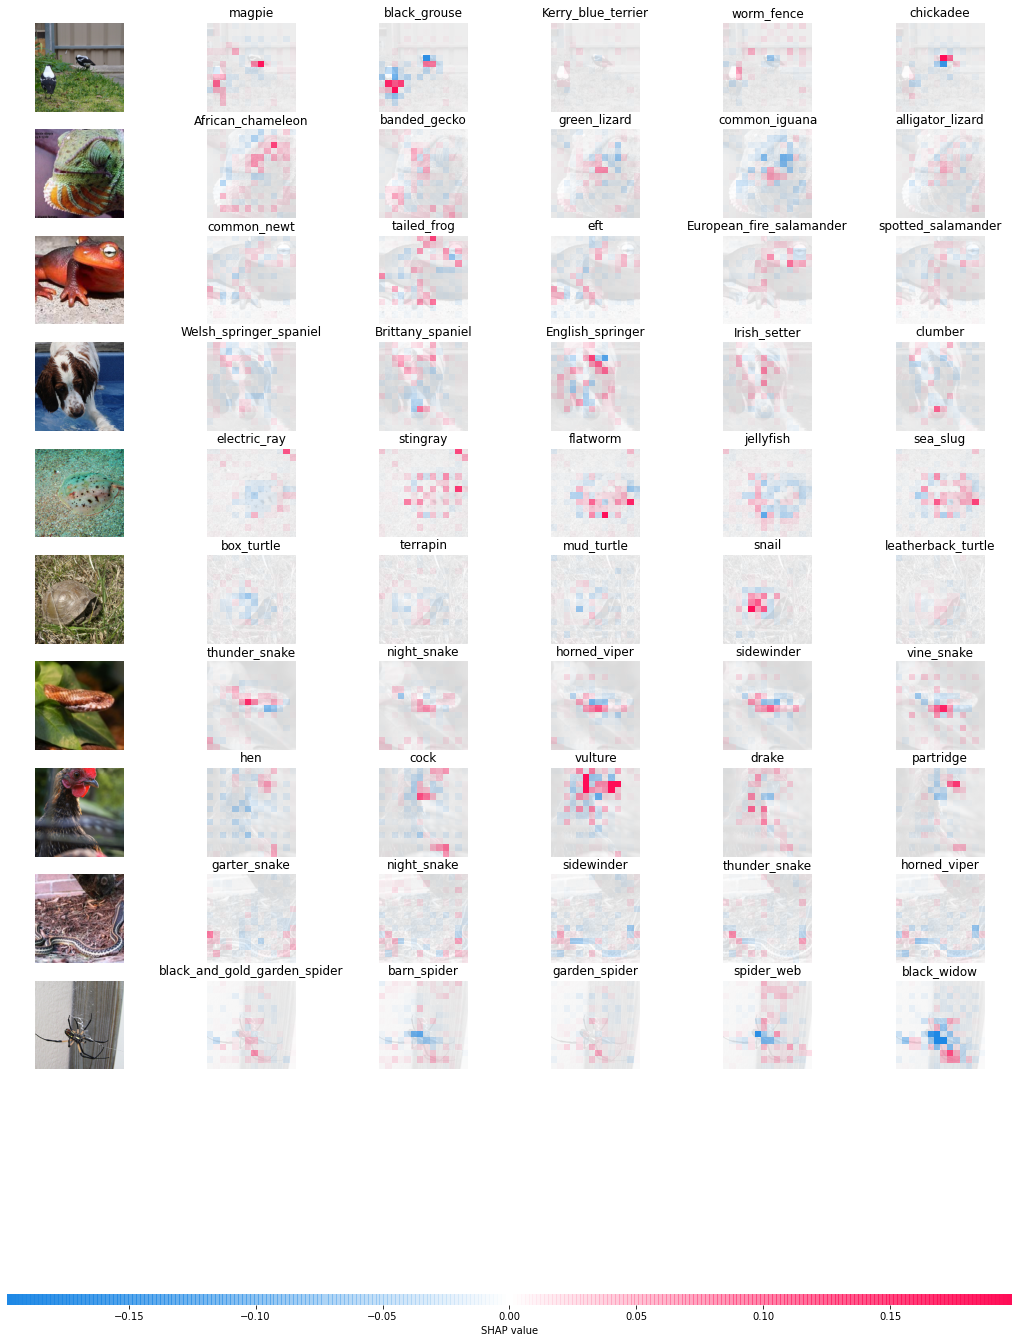

In [ ]:
# layer4
explainer = shap.GradientExplainer((model, model.layer4), background)

shap_values, indices = explainer.shap_values(batch, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())

shap.image_plot(shap_values, denormalize(batch).permute(0, 2, 3, 1).cpu().numpy(), index_names)

torch.Size([10, 3, 224, 224]) torch.Size([1, 3, 1, 1])


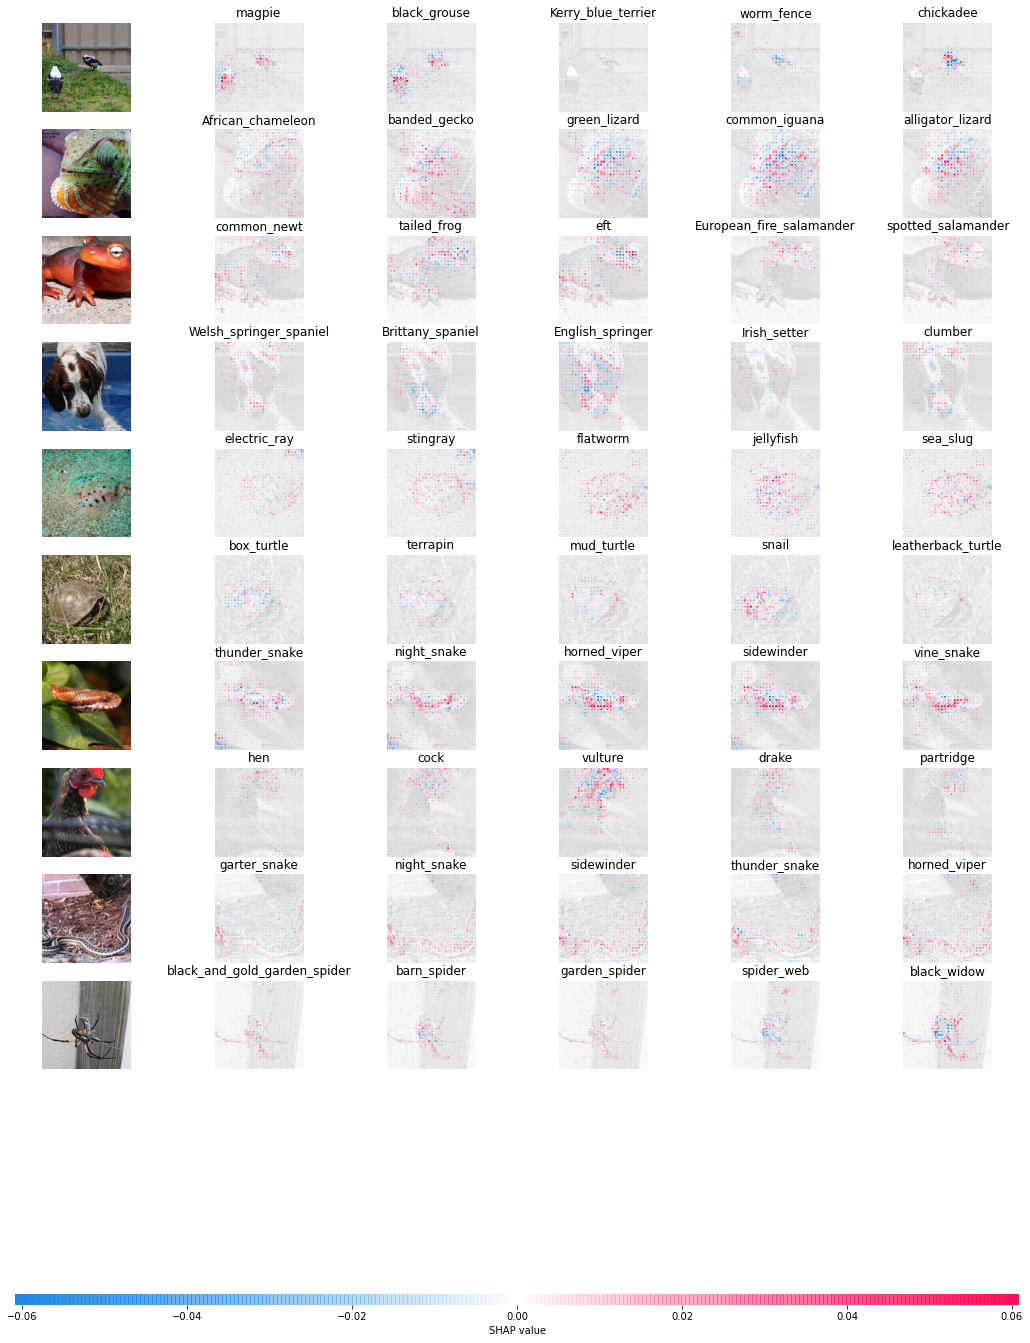

In [ ]:
# layer2
explainer = shap.GradientExplainer((model, model.layer2), background)

shap_values, indices = explainer.shap_values(batch, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())

shap.image_plot(shap_values, denormalize(batch).permute(0, 2, 3, 1).cpu().numpy(), index_names)

## References

* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)
* Same notebook on Google [Colab](https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb)